In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Unzip the repo

In [2]:
%cd /content/drive/MyDrive/DDLS\ final\ project
!unzip -q ddls-essentiality-starter.zip -d ddls-essentiality-repo
%cd ddls-essentiality-repo
!pip -q install -r requirements.txt


/content/drive/MyDrive/DDLS final project
/content/drive/MyDrive/DDLS final project/ddls-essentiality-repo
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 64.6 MB/s eta 0:00:00


Point Config to CSV

In [3]:
import yaml
%cd /content/drive/MyDrive/DDLS final project/ddls-essentiality-repo

cfg_path = "configs/default.yaml"
with open(cfg_path) as f: cfg = yaml.safe_load(f)

cfg['data']['expression'] = "../depmap csv files/OmicsExpressionProteinCodingGenesTPMLogp1.csv"
cfg['data']['ceres']      = "../depmap csv files/CRISPRGeneEffect.csv"
cfg['data']['cnv']        = "../depmap csv files/OmicsCNGene.csv"
cfg['data']['mut']        = "../depmap csv files/OmicsSomaticMutationsProfile.csv"  # NEW

with open(cfg_path, "w") as f: yaml.safe_dump(cfg, f)
!cat configs/default.yaml


/content/drive/MyDrive/DDLS final project/ddls-essentiality-repo
data:
  ceres: ../depmap csv files/CRISPRGeneEffect.csv
  cnv: ../depmap csv files/OmicsCNGene.csv
  expression: ../depmap csv files/OmicsExpressionProteinCodingGenesTPMLogp1.csv
  mut: ../depmap csv files/OmicsSomaticMutationsProfile.csv
  root: ./data
training:
  ae_type: vae
  batch_size: 256
  epochs_ae: 5
  epochs_mlp: 5
  latent_dim: 32
  lr_ae: 1e-3
  lr_mlp: 1e-3
  seed: 42


Fetching the column names of the Mutation file

In [6]:
import pandas as pd
mutp = pd.read_csv(
    "/content/drive/MyDrive/DDLS final project/ddls-essentiality-repo/depmap csv files/OmicsSomaticMutationsProfile.csv",
    nrows=5, low_memory=False
)
print(mutp.columns.tolist())


['Chrom', 'Pos', 'Ref', 'Alt', 'AF', 'DP', 'RefCount', 'AltCount', 'GT', 'PS', 'VariantType', 'VariantInfo', 'DNAChange', 'ProteinChange', 'HugoSymbol', 'EnsemblGeneID', 'EnsemblFeatureID', 'HgncName', 'HgncFamily', 'UniprotID', 'DbsnpRsID', 'GcContent', 'LofGeneName', 'LofGeneId', 'LofNumberOfTranscriptsInGene', 'LofPercentOfTranscriptsAffected', 'NMD', 'MolecularConsequence', 'VepImpact', 'VepBiotype', 'VepHgncID', 'VepExistingVariation', 'VepManeSelect', 'VepENSP', 'VepSwissprot', 'Sift', 'Polyphen', 'GnomadeAF', 'GnomadgAF', 'VepClinSig', 'VepSomatic', 'VepPliGeneValue', 'VepLofTool', 'OncogeneHighImpact', 'TumorSuppressorHighImpact', 'TranscriptLikelyLof', 'Brca1FuncScore', 'CivicID', 'CivicDescription', 'CivicScore', 'LikelyLoF', 'HessDriver', 'HessSignature', 'RevelScore', 'PharmgkbId', 'DidaID', 'DidaName', 'GwasDisease', 'GwasPmID', 'GtexGene', 'ProveanPrediction', 'AMClass', 'AMPathogenicity', 'Rescue', 'ProfileID', 'Hotspot', 'EntrezGeneID']


Convert CSVs → Parquet & align (build binary mutation matrix gene×cell-line)

In [15]:
import os, pandas as pd, numpy as np

root = "/content/drive/MyDrive/DDLS final project/ddls-essentiality-repo"
p_expr  = os.path.join(root, "depmap csv files", "OmicsExpressionProteinCodingGenesTPMLogp1.csv")
p_ceres = os.path.join(root, "depmap csv files", "CRISPRGeneEffect.csv")
p_cnv   = os.path.join(root, "depmap csv files", "OmicsCNGene.csv")
p_mutp  = os.path.join(root, "depmap csv files", "OmicsSomaticMutationsProfile.csv")
p_map   = os.path.join(root, "depmap csv files", "OmicsProfiles.csv")

# Load omics (cells×genes) and normalize gene names
strip_gene = lambda cols: pd.Index([str(c).split(" (")[0] for c in cols])
norm_idx   = lambda idx: pd.Index([str(x).strip().upper() for x in idx])

expr  = pd.read_csv(p_expr,  index_col=0, low_memory=False)
ceres = pd.read_csv(p_ceres, index_col=0, low_memory=False)
cnv   = pd.read_csv(p_cnv,   index_col=0, low_memory=False)
for df in (expr, ceres, cnv): df.columns = strip_gene(df.columns)
expr.index = norm_idx(expr.index); ceres.index = norm_idx(ceres.index); cnv.index = norm_idx(cnv.index)

# Mutation profile (long)
mutp = pd.read_csv(p_mutp, low_memory=False)

# ---- MAPPING: ProfileID -> ModelID (ACH-...) ----
pm = pd.read_csv(p_map, low_memory=False)
# Try to find exact column names (adjust if yours differ)
assert {"ProfileID","ModelID"}.issubset(set(pm.columns)), f"Mapping file must contain ProfileID and ModelID; got {pm.columns.tolist()}"

pm["ProfileID"] = pm["ProfileID"].astype(str).str.upper().str.strip()
pm["ModelID"]   = pm["ModelID"].astype(str).str.upper().str.strip()
profile_to_model = dict(zip(pm["ProfileID"], pm["ModelID"]))

# Build binary mutation matrix (non-silent filter optional)
cell_col, gene_col = "ProfileID", "HugoSymbol"
mutp[cell_col] = mutp[cell_col].astype(str).str.upper().str.strip().map(profile_to_model)
mutp = mutp.dropna(subset=[cell_col, gene_col])

mut_bin = (mutp.assign(val=1)
           .pivot_table(index=cell_col, columns=gene_col, values="val", aggfunc="max", fill_value=0)
           .astype(np.int8))
mut_bin.index = norm_idx(mut_bin.index)
mut_bin.columns = strip_gene(mut_bin.columns)

# Align and save
cells = expr.index.intersection(ceres.index).intersection(cnv.index).intersection(mut_bin.index)
genes = expr.columns.intersection(ceres.columns).intersection(cnv.columns).intersection(mut_bin.columns)
print("Common cells:", len(cells), "Common genes:", len(genes))

outdir = os.path.join(root, "data"); os.makedirs(outdir, exist_ok=True)
expr.loc[cells, genes].to_parquet(os.path.join(outdir, "expression.parquet"))
ceres.loc[cells, genes].to_parquet(os.path.join(outdir, "ceres.parquet"))
cnv.loc[cells, genes].to_parquet(os.path.join(outdir, "cnv.parquet"))
mut_bin.loc[cells, genes].to_parquet(os.path.join(outdir, "mutation_binary.parquet"))
print("Saved.")


Common cells: 1066 Common genes: 17622
Saved.


Train VAE on expression -> cache latents (data/latents.parquet)

In [4]:
# === train_vae.py ===
import os, numpy as np, pandas as pd, torch, torch.nn as nn, torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

ROOT = "/content/drive/MyDrive/DDLS final project/ddls-essentiality-repo"
DATADIR = os.path.join(ROOT, "data")
os.makedirs(DATADIR, exist_ok=True)

# --- Model ---
class Encoder(nn.Module):
    def __init__(self, in_dim, z_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 1024), nn.BatchNorm1d(1024), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(1024, 256), nn.GELU()
        )
        self.mu     = nn.Linear(256, z_dim)
        self.logvar = nn.Linear(256, z_dim)
    def forward(self, x):
        h = self.net(x)
        return self.mu(h), self.logvar(h)

class Decoder(nn.Module):
    def __init__(self, z_dim, out_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(z_dim, 256), nn.GELU(),
            nn.Linear(256, 1024), nn.GELU(),
            nn.Linear(1024, out_dim)
        )
    def forward(self, z): return self.net(z)

class VAE(nn.Module):
    def __init__(self, in_dim, z_dim):
        super().__init__()
        self.enc = Encoder(in_dim, z_dim)
        self.dec = Decoder(z_dim, in_dim)
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    def forward(self, x):
        mu, logvar = self.enc(x)
        z = self.reparameterize(mu, logvar)
        x_hat = self.dec(z)
        return x_hat, mu, logvar, z

def vae_loss(x, x_hat, mu, logvar):
    rec = F.mse_loss(x_hat, x, reduction="mean")
    kld = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return rec + kld, rec.detach(), kld.detach()

# --- Data ---
expr = pd.read_parquet(os.path.join(DATADIR, "expression.parquet"))  # cells x genes
X = torch.tensor(expr.values, dtype=torch.float32)
in_dim = X.shape[1]

# --- Train ---
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vae = VAE(in_dim=in_dim, z_dim=32).to(device)
opt = torch.optim.Adam(vae.parameters(), lr=1e-3, weight_decay=1e-4)
dl = DataLoader(TensorDataset(X), batch_size=256, shuffle=True, drop_last=False)

epochs = 30
scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))
vae.train()
for ep in range(1, epochs+1):
    losses=[]
    for (xb,) in dl:
        xb = xb.to(device, non_blocking=True)
        opt.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=(device=='cuda')):
            xh, mu, lv, _ = vae(xb)
            loss, rec, kld = vae_loss(xb, xh, mu, lv)
        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()
        losses.append(loss.item())
    print(f"[VAE] epoch {ep:02d}/{epochs} loss={np.mean(losses):.4f}")

# --- Cache latents (use mu) ---
vae.eval()
Z = []
with torch.no_grad():
    for (xb,) in DataLoader(TensorDataset(X), batch_size=256, shuffle=False):
        xb = xb.to(device)
        _, mu, _, _ = vae(xb)
        Z.append(mu.cpu().numpy())
Z = np.vstack(Z)
latents = pd.DataFrame(Z, index=expr.index)
latents.to_parquet(os.path.join(DATADIR, "latents.parquet"))
torch.save({'state_dict': vae.state_dict(), 'in_dim': in_dim, 'zdim': 32}, os.path.join(DATADIR, "vae.pt"))
print("Saved:", os.path.join(DATADIR, "latents.parquet"))


/tmp/ipython-input-2579271505.py:65: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=(device=='cuda'))
/tmp/ipython-input-2579271505.py:72: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=(device=='cuda')):


[VAE] epoch 01/30 loss=12.7437
[VAE] epoch 02/30 loss=6.9832
[VAE] epoch 03/30 loss=3.4114
[VAE] epoch 04/30 loss=2.3370
[VAE] epoch 05/30 loss=1.9275
[VAE] epoch 06/30 loss=1.6370
[VAE] epoch 07/30 loss=1.5274
[VAE] epoch 08/30 loss=1.4503
[VAE] epoch 09/30 loss=1.3887
[VAE] epoch 10/30 loss=1.3506
[VAE] epoch 11/30 loss=1.3244
[VAE] epoch 12/30 loss=1.2792
[VAE] epoch 13/30 loss=1.2614
[VAE] epoch 14/30 loss=1.2367
[VAE] epoch 15/30 loss=1.2052
[VAE] epoch 16/30 loss=1.2291
[VAE] epoch 17/30 loss=1.1910
[VAE] epoch 18/30 loss=1.1982
[VAE] epoch 19/30 loss=1.1813
[VAE] epoch 20/30 loss=1.1773
[VAE] epoch 21/30 loss=1.1449
[VAE] epoch 22/30 loss=1.1454
[VAE] epoch 23/30 loss=1.1314
[VAE] epoch 24/30 loss=1.1128
[VAE] epoch 25/30 loss=1.1105
[VAE] epoch 26/30 loss=1.0888
[VAE] epoch 27/30 loss=1.0878
[VAE] epoch 28/30 loss=1.0773
[VAE] epoch 29/30 loss=1.1037
[VAE] epoch 30/30 loss=1.0672
Saved: /content/drive/MyDrive/DDLS final project/ddls-essentiality-repo/data/latents.parquet


MLP-training debugging

In [9]:
# === QUICK-DEBUG MLP (NaN-safe, subset + timing) ===
import os, time, numpy as np, pandas as pd, torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error
from scipy.stats import spearmanr

ROOT = "/content/drive/MyDrive/DDLS final project/ddls-essentiality-repo"
DATADIR = os.path.join(ROOT, "data")

SUBSET_GENES = None
EPOCHS       = 25
BLOCK        = 400
BATCH_SIZE   = 256
LR           = 1e-3
WEIGHT_DECAY = 1e-4
SEED         = 42
MIN_OBS_FRAC = 0.7   # keep genes with >=70% non-NaN CERES in train cells

torch.manual_seed(SEED); np.random.seed(SEED)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device:", device)
if device == 'cuda':
    torch.backends.cudnn.benchmark = True

# ---------- LOAD ----------
latents = pd.read_parquet(os.path.join(DATADIR, "latents.parquet"))
expr    = pd.read_parquet(os.path.join(DATADIR, "expression.parquet"))
cnv     = pd.read_parquet(os.path.join(DATADIR, "cnv.parquet"))
mut     = pd.read_parquet(os.path.join(DATADIR, "mutation_binary.parquet"))
ceres   = pd.read_parquet(os.path.join(DATADIR, "ceres.parquet"))

cells = latents.index.intersection(expr.index).intersection(cnv.index).intersection(mut.index).intersection(ceres.index)
genes = expr.columns.intersection(cnv.columns).intersection(mut.columns).intersection(ceres.columns)
latents = latents.loc[cells]
expr    = expr.loc[cells, genes]
cnv     = cnv.loc[cells, genes]
mut     = mut.loc[cells, genes]
ceres   = ceres.loc[cells, genes]
print("Aligned shapes:", "latents:", latents.shape, "expr:", expr.shape, "cnv:", cnv.shape, "mut:", mut.shape, "ceres:", ceres.shape)

# ---------- SPLIT ----------
train_cells, test_cells = train_test_split(list(cells), test_size=0.2, random_state=SEED)

# ---------- FEATURE CLEANUP ----------
# Fill NaNs in features with per-gene median (computed on ALL cells to avoid train/test leakage on fill)
expr = expr.apply(lambda col: col.fillna(col.median()), axis=0)
cnv  = cnv.apply(lambda col: col.fillna(col.median()), axis=0)
mut  = mut.fillna(0).clip(lower=0, upper=1)  # binary

# Scale expr/cnv per gene (z-score) to stabilize training
def zscore(df):
    m = df.mean(axis=0); s = df.std(axis=0).replace(0, 1.0)
    return (df - m) / s
expr = zscore(expr)
cnv  = zscore(cnv)

# ---------- GENE FILTER: require enough CERES observations in TRAIN cells ----------
ceres_train = ceres.loc[train_cells]
obs_frac = 1.0 - ceres_train.isna().mean(axis=0)  # per-gene fraction of non-NaN
keep_genes = list(obs_frac[obs_frac >= MIN_OBS_FRAC].index)
if SUBSET_GENES is not None:
    keep_genes = keep_genes[:SUBSET_GENES]
print(f"Keeping {len(keep_genes)} genes (MIN_OBS_FRAC={MIN_OBS_FRAC}).")

expr  = expr[keep_genes]
cnv   = cnv[keep_genes]
mut   = mut[keep_genes]
ceres = ceres[keep_genes]

# ---------- BUILD BLOCKS ----------
def build_block(cell_index, gene_block):
    Z = latents.loc[cell_index].values
    rows, y = [], []
    for g in gene_block:
        y_g = ceres.loc[cell_index, g].values
        mask = ~np.isnan(y_g)                     # drop (cell,gene) with NaN CERES
        if not mask.any():
            continue
        Xg = np.hstack([
            Z[mask],
            expr.loc[cell_index, g].values.reshape(-1,1)[mask],
            cnv.loc[cell_index,  g].values.reshape(-1,1)[mask],
            mut.loc[cell_index,  g].values.reshape(-1,1)[mask],
        ])
        rows.append(Xg.astype('float32'))
        y.append(y_g[mask].astype('float32').reshape(-1,1))
    if len(rows)==0:
        return None, None
    X = np.vstack(rows); Y = np.vstack(y)
    # final safety: replace any residual inf/nan in features
    X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
    Y = np.nan_to_num(Y, nan=0.0)  # shouldn't happen due to mask, but safe
    return X, Y

# ---------- MODEL ----------
class MLPHead(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256), nn.LayerNorm(256), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(256, 64),    nn.GELU(), nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

in_dim = latents.shape[1] + 3
model = MLPHead(in_dim).to(device)
opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
loss_fn = nn.SmoothL1Loss()

blocks = [keep_genes[i:i+BLOCK] for i in range(0, len(keep_genes), BLOCK)]
print(f"Blocks per epoch: {len(blocks)} (BLOCK={BLOCK})")

# ---------- TRAIN ----------
for ep in range(1, EPOCHS+1):
    model.train()
    t0 = time.time()
    losses=[]
    for gb in blocks:
        Xb, yb = build_block(train_cells, gb)
        if Xb is None:  # no observations in this block
            continue
        ds = TensorDataset(torch.tensor(Xb), torch.tensor(yb))
        dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=False,
                        pin_memory=(device=='cuda'), num_workers=2)
        for xb, y in dl:
            xb = xb.to(device, non_blocking=True); y = y.to(device, non_blocking=True)
            opt.zero_grad(set_to_none=True)
            pred = model(xb)
            loss = loss_fn(pred, y)
            loss.backward(); opt.step()
            losses.append(float(loss))
    dt = time.time() - t0
    print(f"[MLP] epoch {ep:02d}/{EPOCHS} | loss={np.mean(losses) if losses else np.nan:.4f} | time={dt:.1f}s")

# ---------- EVAL (subset gene set) ----------
model.eval()
preds, truth = [], []
with torch.no_grad():
    for gb in blocks:
        Xb, yb = build_block(test_cells, gb)
        if Xb is None:
            continue
        ds = TensorDataset(torch.tensor(Xb), torch.tensor(yb))
        dl = DataLoader(ds, batch_size=BATCH_SIZE, shuffle=False, drop_last=False,
                        pin_memory=(device=='cuda'), num_workers=2)
        for xb, y in dl:
            xb = xb.to(device, non_blocking=True)
            p = model(xb).detach().cpu().numpy().ravel()
            preds.append(p); truth.append(y.numpy().ravel())

preds = np.concatenate(preds); truth = np.concatenate(truth)
print("\nQuick-debug metrics (subset):")
print("  R²       :", r2_score(truth, preds))
print("  MAE      :", mean_absolute_error(truth, preds))
print("  Spearman :", spearmanr(truth, preds).statistic)


Device: cuda
Aligned shapes: latents: (1066, 32) expr: (1066, 17622) cnv: (1066, 17622) mut: (1066, 17622) ceres: (1066, 17622)
Keeping 17063 genes (MIN_OBS_FRAC=0.7).
Blocks per epoch: 43 (BLOCK=400)
[MLP] epoch 01/25 | loss=0.0713 | time=326.8s
[MLP] epoch 02/25 | loss=0.0713 | time=309.8s
[MLP] epoch 03/25 | loss=0.0713 | time=311.3s
[MLP] epoch 04/25 | loss=0.0713 | time=310.1s
[MLP] epoch 05/25 | loss=0.0713 | time=309.6s
[MLP] epoch 06/25 | loss=0.0713 | time=308.0s
[MLP] epoch 07/25 | loss=0.0713 | time=309.9s
[MLP] epoch 08/25 | loss=0.0713 | time=308.3s
[MLP] epoch 09/25 | loss=0.0713 | time=307.0s
[MLP] epoch 10/25 | loss=0.0713 | time=307.8s
[MLP] epoch 11/25 | loss=0.0713 | time=306.5s
[MLP] epoch 12/25 | loss=0.0713 | time=306.5s
[MLP] epoch 13/25 | loss=0.0713 | time=305.8s
[MLP] epoch 14/25 | loss=0.0713 | time=305.3s
[MLP] epoch 15/25 | loss=0.0713 | time=305.7s
[MLP] epoch 16/25 | loss=0.0713 | time=304.6s
[MLP] epoch 17/25 | loss=0.0713 | time=304.9s
[MLP] epoch 18/25

In [15]:
# Mount & cd (if not already)
from google.colab import drive, runtime
drive.mount('/content/drive', force_remount=True)
%cd "/content/drive/MyDrive/DDLS final project/ddls-essentiality-repo"

# List likely locations
import glob, os
print("data/:", os.listdir("data") if os.path.exists("data") else "no data dir")
print("Any *.pt under repo?:")
for p in glob.glob("**/*.pt", recursive=True):
    print(" -", p)


Mounted at /content/drive
/content/drive/MyDrive/DDLS final project/ddls-essentiality-repo
data/: ['expression.parquet', 'ceres.parquet', 'cnv.parquet', 'mutation_binary.parquet', 'latents.parquet', 'vae.pt']
Any *.pt under repo?:
 - data/vae.pt


In [14]:
# This assumes `model` (your trained MLP) and `latents` are still in memory
import torch, os
in_dim = latents.shape[1] + 3  # [Z + expr_g + cnv_g + mut_g]
os.makedirs("data", exist_ok=True)
torch.save({'state_dict': model.state_dict(), 'in_dim': in_dim}, "data/mlp.pt")
print("Saved -> data/mlp.pt")


Saved -> data/mlp.pt


In [16]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, glob, shutil, sys
ROOT = "/content/drive/MyDrive/DDLS final project/ddls-essentiality-repo"
print("ROOT exists:", os.path.exists(ROOT))
cands = []
for base in [ROOT, "/content", "/content/drive"]:
    for p in glob.glob(os.path.join(base, "**", "*.pt"), recursive=True):
        cands.append(p)
print("Found .pt files:", len(cands))
for p in sorted(cands)[:50]:
    print(" -", p)

DATADIR = os.path.join(ROOT, "data")
os.makedirs(DATADIR, exist_ok=True)

# Prefer exact mlp.pt, else mlp_quickdebug.pt, else any *.pt that looks like MLP
dest = os.path.join(DATADIR, "mlp.pt")
picked = None
for name in ["mlp.pt", "mlp_quickdebug.pt"]:
    for p in cands:
        if p.endswith(name):
            picked = p; break
    if picked: break
if not picked:
    # last resort: pick any *.pt under repo/src or repo/data
    for p in cands:
        if ROOT in p and ("/data/" in p or "/src/" in p):
            picked = p; break

if picked:
    shutil.copy(picked, dest)
    print("✔ Copied checkpoint:", picked, "->", dest)
else:
    print("✘ No checkpoint found to copy.")


Mounted at /content/drive
ROOT exists: True
Found .pt files: 4
 - /content/data/mlp.pt
 - /content/drive/MyDrive/DDLS final project/ddls-essentiality-repo/data/vae.pt
 - /content/drive/MyDrive/DDLS final project/ddls-essentiality-repo/data/vae.pt
 - /content/drive/MyDrive/DDLS final project/ddls-essentiality-repo/data/vae.pt
✔ Copied checkpoint: /content/data/mlp.pt -> /content/drive/MyDrive/DDLS final project/ddls-essentiality-repo/data/mlp.pt


Evaluate (metrics + tables)

Metrics: {'r2': 0.019939184188842773, 'mae': 0.24385425448417664, 'spearman': 0.1361677594056939, 'roc_auc': 0.6295751882170416, 'pr_auc': 0.15198794607690047}
Saved figures to: /content/drive/MyDrive/DDLS final project/ddls-essentiality-repo/figs


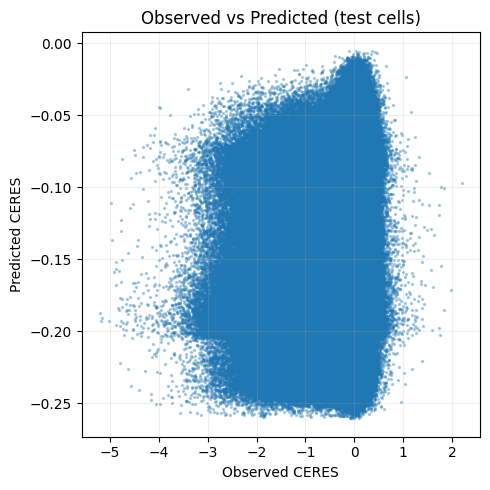

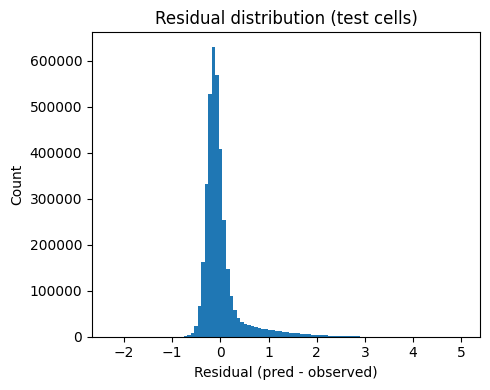

In [19]:
# === EVAL (NaN-safe) ===
import os, json, numpy as np, pandas as pd, torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, roc_auc_score, average_precision_score
from scipy.stats import spearmanr
import matplotlib.pyplot as plt

ROOT = "/content/drive/MyDrive/DDLS final project/ddls-essentiality-repo"
DATADIR = os.path.join(ROOT, "data")
FIGDIR  = os.path.join(ROOT, "figs"); os.makedirs(FIGDIR, exist_ok=True)

# Load data
latents = pd.read_parquet(os.path.join(DATADIR, "latents.parquet"))
expr    = pd.read_parquet(os.path.join(DATADIR, "expression.parquet"))
cnv     = pd.read_parquet(os.path.join(DATADIR, "cnv.parquet"))
mut     = pd.read_parquet(os.path.join(DATADIR, "mutation_binary.parquet"))
ceres   = pd.read_parquet(os.path.join(DATADIR, "ceres.parquet"))

# Align
cells = latents.index.intersection(expr.index).intersection(cnv.index).intersection(mut.index).intersection(ceres.index)
genes = expr.columns.intersection(cnv.columns).intersection(mut.columns).intersection(ceres.columns)
latents = latents.loc[cells]; expr=expr.loc[cells, genes]; cnv=cnv.loc[cells, genes]; mut=mut.loc[cells, genes]; ceres=ceres.loc[cells, genes]

# --- Impute and scale features like training ---
expr = expr.apply(lambda c: c.fillna(c.median()), axis=0)
cnv  = cnv.apply(lambda c: c.fillna(c.median()), axis=0)
mut  = mut.fillna(0).clip(0,1)

def zscore(df):
    m = df.mean(axis=0); s = df.std(axis=0).replace(0, 1.0)
    return (df - m) / s
expr = zscore(expr); cnv = zscore(cnv)

# Split cells (same seed)
train_cells, test_cells = train_test_split(list(cells), test_size=0.2, random_state=42)

# Build features for test cells; drop NaN CERES per (cell,gene)
def build_block(cell_index, gene_block):
    Z = latents.loc[cell_index].values
    rows, y = [], []
    for g in gene_block:
        y_g = ceres.loc[cell_index, g].values
        mask = ~np.isnan(y_g)
        if not mask.any():
            continue
        Xg = np.hstack([
            Z[mask],
            expr.loc[cell_index, g].values.reshape(-1,1)[mask],
            cnv.loc[cell_index,  g].values.reshape(-1,1)[mask],
            mut.loc[cell_index,  g].values.reshape(-1,1)[mask],
        ]).astype('float32')
        rows.append(Xg); y.append(y_g[mask].astype('float32'))
    if not rows:
        return None, None
    X = np.vstack(rows); Y = np.concatenate(y)
    # final safety: replace any residual non-finite values
    X = np.nan_to_num(X, nan=0.0, posinf=1e6, neginf=-1e6)
    Y = np.nan_to_num(Y, nan=0.0)
    return X, Y

# Load model (mlp.pt or fallback)
ckpt_path = None
for cand in ["mlp.pt", "mlp_quickdebug.pt"]:
    p = os.path.join(DATADIR, cand)
    if os.path.exists(p):
        ckpt_path = p; break
assert ckpt_path, "No MLP checkpoint found in data/."

import torch.nn as nn
class MLPHead(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256), nn.LayerNorm(256), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(256, 64),    nn.GELU(), nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

ckpt = torch.load(ckpt_path, map_location='cpu')
model = MLPHead(ckpt['in_dim']); model.load_state_dict(ckpt['state_dict']); model.eval()

# Inference over all genes in blocks
BLOCK = 400
glist = list(genes)
preds, truth = [], []
for i in range(0, len(glist), BLOCK):
    gb = glist[i:i+BLOCK]
    Xb, yb = build_block(test_cells, gb)
    if Xb is None:
        continue
    with torch.no_grad():
        p = model(torch.tensor(Xb)).numpy().ravel()
    preds.append(p); truth.append(yb.ravel())

preds = np.concatenate(preds); truth = np.concatenate(truth)

# Filter any remaining non-finite pairs (defensive)
m = np.isfinite(preds) & np.isfinite(truth)
preds, truth = preds[m], truth[m]

# Metrics
from sklearn.metrics import r2_score, mean_absolute_error, roc_auc_score, average_precision_score
from scipy.stats import spearmanr
metrics = {
    "r2": float(r2_score(truth, preds)),
    "mae": float(mean_absolute_error(truth, preds)),
    "spearman": float(spearmanr(truth, preds).statistic),
}

# Optional classification view (CERES < -0.5)
thr = -0.5
y_bin = (truth < thr).astype(int)
try:
    metrics.update({
        "roc_auc": float(roc_auc_score(y_bin, -preds)),
        "pr_auc": float(average_precision_score(y_bin, -preds)),
    })
except Exception:
    pass

with open(os.path.join(DATADIR, "metrics_test.json"), "w") as f:
    json.dump(metrics, f, indent=2)
print("Metrics:", metrics)

# Figures
plt.figure(figsize=(5,5))
plt.scatter(truth, preds, s=2, alpha=0.3)
plt.xlabel("Observed CERES"); plt.ylabel("Predicted CERES")
plt.title("Observed vs Predicted (test cells)")
plt.grid(True, alpha=0.2); plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "obs_vs_pred_test.png"), dpi=200)

resid = preds - truth
plt.figure(figsize=(5,4))
plt.hist(resid, bins=100)
plt.xlabel("Residual (pred - observed)"); plt.ylabel("Count")
plt.title("Residual distribution (test cells)")
plt.tight_layout()
plt.savefig(os.path.join(FIGDIR, "residual_hist_test.png"), dpi=200)

print("Saved figures to:", FIGDIR)


In [24]:
import os, subprocess, sys
os.chdir('/content')  # ensure we're not inside a broken mount

# See if Drive is mounted
print("Mounted entries containing '/content/drive':")
print(subprocess.getoutput("mount | grep /content/drive") or "<none>")


Mounted entries containing '/content/drive':
<none>


In [25]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [26]:
%cd "/content/drive/MyDrive/DDLS final project/ddls-essentiality-repo"
!ls -lah


/content/drive/MyDrive/DDLS final project/ddls-essentiality-repo
total 71K
drwx------ 2 root root 4.0K Oct 29 12:51  app
-rw------- 1 root root   90 Oct 29 12:34  CITATION.cff
drwx------ 2 root root 4.0K Oct 29 12:51  configs
drwx------ 2 root root 4.0K Oct 29 17:27  data
drwx------ 2 root root 4.0K Oct 29 13:21 'depmap csv files'
-rw------- 1 root root  323 Oct 29 12:34  environment.yml
drwx------ 2 root root 4.0K Oct 29 17:27  figs
-rw------- 1 root root   57 Oct 29 12:34  LICENSE
drwx------ 2 root root 4.0K Oct 29 12:51  notebooks
drwx------ 2 root root 4.0K Oct 29 17:36  outputs
-rw------- 1 root root   72 Oct 29 12:34  README.md
-rw------- 1 root root  36K Oct 29 12:34  report_template.docx
-rw------- 1 root root   18 Oct 29 12:34  report_template.md
-rw------- 1 root root  132 Oct 29 12:34  requirements.txt
drwx------ 2 root root 4.0K Oct 29 12:51  src


In [27]:
!mkdir -p /content/work/{data,figs}
!cp -f "data/latents.parquet" /content/work/data/


Latent UMAP Figures

In [28]:
# ---- LATENT VISUALS: PCA(2) and PCA->UMAP, local run then copy to Drive ----
import os, time, numpy as np, pandas as pd, matplotlib.pyplot as plt

# 0) Paths
LOCAL_DATA = "/content/work/data"
LOCAL_FIGS = "/content/work/figs"
DRIVE_FIGS = "/content/drive/MyDrive/DDLS final project/ddls-essentiality-repo/figs"
os.makedirs(LOCAL_FIGS, exist_ok=True)
os.makedirs(DRIVE_FIGS, exist_ok=True)

# 1) Load latents (cells x z)
latents_path = os.path.join(LOCAL_DATA, "latents.parquet")
latents = pd.read_parquet(latents_path).values
n_cells, zdim = latents.shape
print(f"Latents: {latents.shape}")

# 2) PCA(2) quick plot (always fast)
from sklearn.decomposition import PCA
t0 = time.time()
pca2 = PCA(n_components=2, random_state=42).fit_transform(latents)
plt.figure(figsize=(5,5))
plt.scatter(pca2[:,0], pca2[:,1], s=5, alpha=0.6)
plt.title("PCA(2) of VAE Latents (cells)")
plt.axis("off"); plt.tight_layout()
pca_png = os.path.join(LOCAL_FIGS, "latent_pca2.png")
plt.savefig(pca_png, dpi=200)
plt.close()
print(f"Saved PCA(2) -> {pca_png} ({time.time()-t0:.1f}s)")

# 3) UMAP on PCA(50) (stable & much faster than raw-dim UMAP)
#    Install umap-learn if needed
try:
    import umap
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "umap-learn"])
    import umap

# PCA -> 50 comps (or zdim if < 50)
t1 = time.time()
pca_dim = min(50, zdim)
pca50 = PCA(n_components=pca_dim, random_state=42).fit_transform(latents)

um = umap.UMAP(
    n_neighbors=min(15, n_cells-1),
    min_dist=0.1,
    n_components=2,
    metric="cosine",
    n_epochs=200,          # lower for speed; raise to 500 for a touch smoother
    low_memory=True,
    random_state=42,
    verbose=True
)
emb = um.fit_transform(pca50)

plt.figure(figsize=(5,5))
plt.scatter(emb[:,0], emb[:,1], s=5, alpha=0.6)
plt.title("UMAP of VAE Latents (PCA→UMAP, cosine)")
plt.axis("off"); plt.tight_layout()
umap_png = os.path.join(LOCAL_FIGS, "latent_umap.png")
plt.savefig(umap_png, dpi=200)
plt.close()
print(f"Saved UMAP -> {umap_png} ({time.time()-t1:.1f}s)")

# 4) Copy results back to Drive
import shutil
for f in [pca_png, umap_png]:
    dest = os.path.join(DRIVE_FIGS, os.path.basename(f))
    shutil.copy2(f, dest)
    print("Copied to Drive:", dest)

print("\nDone. Figures are in:")
print(" -", pca_png)
print(" -", umap_png)
print("and copied to:", DRIVE_FIGS)


Latents: (1066, 32)
Saved PCA(2) -> /content/work/figs/latent_pca2.png (0.2s)


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


UMAP(angular_rp_forest=True, metric='cosine', n_epochs=200, n_jobs=1, random_state=42, verbose=True)
Wed Oct 29 17:49:21 2025 Construct fuzzy simplicial set
Wed Oct 29 17:49:22 2025 Finding Nearest Neighbors
Wed Oct 29 17:49:25 2025 Finished Nearest Neighbor Search
Wed Oct 29 17:49:27 2025 Construct embedding


Epochs completed:   0%|            0/200 [00:00]

	completed  0  /  200 epochs
	completed  20  /  200 epochs
	completed  40  /  200 epochs
	completed  60  /  200 epochs
	completed  80  /  200 epochs
	completed  100  /  200 epochs
	completed  120  /  200 epochs
	completed  140  /  200 epochs
	completed  160  /  200 epochs
	completed  180  /  200 epochs
Wed Oct 29 17:49:29 2025 Finished embedding
Saved UMAP -> /content/work/figs/latent_umap.png (8.3s)
Copied to Drive: /content/drive/MyDrive/DDLS final project/ddls-essentiality-repo/figs/latent_pca2.png
Copied to Drive: /content/drive/MyDrive/DDLS final project/ddls-essentiality-repo/figs/latent_umap.png

Done. Figures are in:
 - /content/work/figs/latent_pca2.png
 - /content/work/figs/latent_umap.png
and copied to: /content/drive/MyDrive/DDLS final project/ddls-essentiality-repo/figs


Small predictions CSV for appendix

In [29]:
# ---- SAMPLE PREDICTIONS (for appendix) ----
import os, json, numpy as np, pandas as pd, torch
from sklearn.model_selection import train_test_split

# === Paths ===
ROOT = "/content/drive/MyDrive/DDLS final project/ddls-essentiality-repo"
DATADIR = os.path.join(ROOT, "data")
OUTDIR  = os.path.join(ROOT, "outputs")
os.makedirs(OUTDIR, exist_ok=True)

# === Load data ===
latents = pd.read_parquet(os.path.join(DATADIR, "latents.parquet"))
expr    = pd.read_parquet(os.path.join(DATADIR, "expression.parquet"))
cnv     = pd.read_parquet(os.path.join(DATADIR, "cnv.parquet"))
mut     = pd.read_parquet(os.path.join(DATADIR, "mutation_binary.parquet"))
ceres   = pd.read_parquet(os.path.join(DATADIR, "ceres.parquet"))

# Align shapes
cells = latents.index.intersection(expr.index).intersection(cnv.index).intersection(mut.index).intersection(ceres.index)
genes = expr.columns.intersection(cnv.columns).intersection(mut.columns).intersection(ceres.columns)
latents = latents.loc[cells]; expr=expr.loc[cells,genes]; cnv=cnv.loc[cells,genes]; mut=mut.loc[cells,genes]; ceres=ceres.loc[cells,genes]
print("Aligned:", len(cells), "cells ×", len(genes), "genes")

# === Split like training (holdout 20% cells) ===
_, test_cells = train_test_split(list(cells), test_size=0.2, random_state=42)

# === Load trained model ===
ckpt_path = None
for cand in ["mlp.pt", "mlp_quickdebug.pt"]:
    p = os.path.join(DATADIR, cand)
    if os.path.exists(p):
        ckpt_path = p; break
assert ckpt_path, "No MLP checkpoint found in data/."
print("Using checkpoint:", ckpt_path)

import torch.nn as nn
class MLPHead(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim,256), nn.LayerNorm(256), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(256,64), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(64,1)
        )
    def forward(self,x): return self.net(x)

ckpt = torch.load(ckpt_path, map_location='cpu')
model = MLPHead(ckpt['in_dim']); model.load_state_dict(ckpt['state_dict']); model.eval()

# === Predict random pairs ===
rng = np.random.default_rng(42)
N = 100  # number of pairs
pairs = list(zip(rng.choice(test_cells, size=N, replace=True),
                 rng.choice(list(genes), size=N, replace=True)))

rows = []
for cell_id, gene_id in pairs:
    ceres_val = ceres.loc[cell_id, gene_id]
    if np.isnan(ceres_val):
        continue
    z  = latents.loc[cell_id].values.reshape(1, -1)
    xg = np.array([[expr.loc[cell_id, gene_id],
                    cnv.loc[cell_id, gene_id],
                    mut.loc[cell_id, gene_id]]], dtype=np.float32)
    X = np.hstack([z, xg]).astype(np.float32)
    with torch.no_grad():
        pred = float(model(torch.tensor(X)).numpy().ravel()[0])
    rows.append({
        "cell_line": cell_id,
        "gene": gene_id,
        "predicted_CERES": pred,
        "observed_CERES": float(ceres_val)
    })

pred_df = pd.DataFrame(rows)
csv_path_local = "/content/work/sample_predictions_test.csv"
csv_path_drive = os.path.join(OUTDIR, "sample_predictions_test.csv")

pred_df.to_csv(csv_path_local, index=False)
pred_df.to_csv(csv_path_drive, index=False)
print(f"Saved {len(pred_df)} predictions ->")
print(" - Local :", csv_path_local)
print(" - Drive :", csv_path_drive)

# Preview first 5 rows
pred_df.head()


Aligned: 1066 cells × 17622 genes
Using checkpoint: /content/drive/MyDrive/DDLS final project/ddls-essentiality-repo/data/mlp.pt
Saved 95 predictions ->
 - Local : /content/work/sample_predictions_test.csv
 - Drive : /content/drive/MyDrive/DDLS final project/ddls-essentiality-repo/outputs/sample_predictions_test.csv


,cell_line,gene,predicted_CERES,observed_CERES
0,ACH-000939,CALHM1,-0.167320,0.029493
1,ACH-000570,INPP4B,-0.159883,0.133477
2,ACH-000295,REC114,-0.098091,0.171558
3,ACH-002659,BAIAP2L1,-0.147415,0.218740
4,ACH-001662,LIMK2,-0.145524,0.253560


Gradio App

In [32]:
# ==== Essentiality Predictor App (Gradio) ====
# Features: [Z_cell, expr_g (zscored), cnv_g (zscored), mut_g] -> predicted CERES
# Inputs: pick ACH-... cell line; provide genes (text or CSV with 'gene' column)
# Outputs: table (gene, predicted_CERES, observed_CERES if available) + downloadable CSV

import os, io, tempfile, numpy as np, pandas as pd, torch, torch.nn as nn
import gradio as gr

# ---------- Paths ----------
ROOT   = "/content/drive/MyDrive/DDLS final project/ddls-essentiality-repo"
DATA   = os.path.join(ROOT, "data")
FIGS   = os.path.join(ROOT, "figs")
OUTDIR = os.path.join(ROOT, "outputs")
os.makedirs(OUTDIR, exist_ok=True)

# ---------- Load matrices ----------
latents = pd.read_parquet(os.path.join(DATA, "latents.parquet"))              # cells x z
expr    = pd.read_parquet(os.path.join(DATA, "expression.parquet"))           # cells x genes
cnv     = pd.read_parquet(os.path.join(DATA, "cnv.parquet"))                  # cells x genes
mut     = pd.read_parquet(os.path.join(DATA, "mutation_binary.parquet"))      # cells x genes
ceres   = pd.read_parquet(os.path.join(DATA, "ceres.parquet"))                # cells x genes (optional for display)

# Align everything (defensive)
cells = latents.index.intersection(expr.index).intersection(cnv.index).intersection(mut.index)
genes = expr.columns.intersection(cnv.columns).intersection(mut.columns)
latents = latents.loc[cells]
expr    = expr.loc[cells, genes]
cnv     = cnv.loc[cells, genes]
mut     = mut.loc[cells, genes]
# ceres may have NaNs / fewer genes
ceres   = ceres.reindex(index=cells, columns=genes)

# ---------- Preprocessing (same as training) ----------
# Fill NaNs (expr, cnv): per-gene median; Scale (z-score per gene); mut: binary (0/1) fill 0
expr = expr.apply(lambda col: col.fillna(col.median()), axis=0)
cnv  = cnv.apply(lambda col: col.fillna(col.median()), axis=0)
mut  = mut.fillna(0).clip(0, 1)

def zscore(df: pd.DataFrame) -> pd.DataFrame:
    m = df.mean(axis=0)
    s = df.std(axis=0).replace(0, 1.0)
    return (df - m) / s

expr_z = zscore(expr)
cnv_z  = zscore(cnv)

# ---------- Load model ----------
ckpt_path = None
for cand in ["mlp.pt", "mlp_quickdebug.pt"]:
    p = os.path.join(DATA, cand)
    if os.path.exists(p):
        ckpt_path = p
        break
assert ckpt_path, "No MLP checkpoint found in data/ (expected mlp.pt or mlp_quickdebug.pt)."

class MLPHead(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256), nn.LayerNorm(256), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(256, 64),    nn.GELU(), nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

ckpt = torch.load(ckpt_path, map_location="cpu")
model = MLPHead(ckpt["in_dim"])
model.load_state_dict(ckpt["state_dict"])
model.eval()

# ---------- Inference helper ----------
def predict_for_cell(cell_id: str, gene_list):
    # Filter to genes present
    g_ok = [g for g in gene_list if g in genes]
    missing = sorted(set(gene_list) - set(g_ok))
    if len(g_ok) == 0:
        return pd.DataFrame(columns=["gene","predicted_CERES","observed_CERES"]), "", f"No valid genes among: {gene_list[:10]} ..."

    # Build features per gene
    z = latents.loc[cell_id].values.reshape(1, -1)
    rows = []
    for g in g_ok:
        xg = np.array([[expr_z.loc[cell_id, g], cnv_z.loc[cell_id, g], mut.loc[cell_id, g]]], dtype=np.float32)
        X  = np.hstack([z, xg]).astype(np.float32)
        with torch.no_grad():
            p = float(model(torch.tensor(X)).numpy().ravel()[0])
        obs = ceres.loc[cell_id, g] if (cell_id in ceres.index and g in ceres.columns) else np.nan
        rows.append({"gene": g, "predicted_CERES": p, "observed_CERES": (None if pd.isna(obs) else float(obs))})
    df = pd.DataFrame(rows)

    # Save a downloadable CSV (temp file, Gradio will handle)
    tmp_path = os.path.join(OUTDIR, f"predictions_{cell_id}.csv")
    df.to_csv(tmp_path, index=False)

    # Info message about missing genes
    msg = ""
    if missing:
        msg = f"{len(missing)} gene(s) were not in the matrices and were skipped (e.g., {missing[:5]} ...)."
    return df, tmp_path, msg

# ---------- Gradio UI ----------
def _run(cell_id, genes_text, genes_file):
    # Genes from text (comma/space/newline separated)
    text_genes = []
    if genes_text:
        # split on commas or whitespace, strip
        text_genes = [g.strip() for g in genes_text.replace(",", " ").split() if g.strip()]

    # Genes from CSV upload (expects a column named 'gene' or first column)
    file_genes = []
    if genes_file is not None:
        try:
            dfu = pd.read_csv(genes_file.name)
            col = "gene" if "gene" in [c.lower() for c in dfu.columns] else dfu.columns[0]
            file_genes = [str(x).strip() for x in dfu[col].tolist()]
        except Exception as e:
            return None, None, f"Could not parse uploaded file: {e}"

    # Combine & unique, keep order
    seen = set(); merged = []
    for g in text_genes + file_genes:
        if g and g not in seen:
            merged.append(g); seen.add(g)

    if not merged:
        return None, None, "Please enter genes (comma/newline-separated) and/or upload a CSV with a 'gene' column."

    df, csv_path, msg = predict_for_cell(cell_id, merged)
    return df, csv_path, (msg or "Done.")

with gr.Blocks() as demo:
    gr.Markdown("## 🔬 Essentiality Predictor (VAE→MLP)\n"
                "Predict CRISPR gene effect (CERES) from expression/CNV/mutation features.\n"
                "Provide a cell line (ACH-…) and one or more gene symbols.")
    with gr.Row():
        cell_in = gr.Dropdown(choices=list(latents.index), label="Cell line (ACH-…)", value=list(latents.index)[0], scale=1)
        genes_in = gr.Textbox(label="Genes (comma/newline-separated)", placeholder="e.g., KRAS, TP53, MYC", lines=3)
        file_in  = gr.File(label="Or upload CSV with column 'gene' (optional)", file_types=[".csv"])
    run_btn = gr.Button("Predict", variant="primary")
    info    = gr.Markdown("")
    with gr.Row():
        tbl_out = gr.Dataframe(headers=["gene","predicted_CERES","observed_CERES"], wrap=True, label="Predictions")
    dl_out = gr.File(label="Download CSV")

    def _on_click(cell, gtext, gfile):
        df, csvp, msg = _run(cell, gtext, gfile)
        if df is None:
            return gr.update(value=None), gr.update(value=None), gr.update(value=f"⚠️ {msg}")
        return df, csvp, f"✅ {msg}"

    run_btn.click(_on_click, inputs=[cell_in, genes_in, file_in], outputs=[tbl_out, dl_out, info])

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6944811d2cbea66948.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [33]:
# ==== Essentiality Predictor App (VAE→MLP) with Essential/Non-essential calls ====
# Threshold-based call: Essential if CERES < threshold (default: -0.5)
# Outputs: table + CSV + summary counts (and observed labels if available)

import os, io, numpy as np, pandas as pd, torch, torch.nn as nn
import gradio as gr

# ---------- Paths ----------
ROOT   = "/content/drive/MyDrive/DDLS final project/ddls-essentiality-repo"
DATA   = os.path.join(ROOT, "data")
OUTDIR = os.path.join(ROOT, "outputs"); os.makedirs(OUTDIR, exist_ok=True)

# ---------- Load matrices ----------
latents = pd.read_parquet(os.path.join(DATA, "latents.parquet"))              # cells x z
expr    = pd.read_parquet(os.path.join(DATA, "expression.parquet"))           # cells x genes
cnv     = pd.read_parquet(os.path.join(DATA, "cnv.parquet"))                  # cells x genes
mut     = pd.read_parquet(os.path.join(DATA, "mutation_binary.parquet"))      # cells x genes
ceres   = pd.read_parquet(os.path.join(DATA, "ceres.parquet"))                # cells x genes (observed; may have NaNs)

# Align indices/columns
cells = latents.index.intersection(expr.index).intersection(cnv.index).intersection(mut.index)
genes = expr.columns.intersection(cnv.columns).intersection(mut.columns)
latents = latents.loc[cells]
expr    = expr.loc[cells, genes]
cnv     = cnv.loc[cells, genes]
mut     = mut.loc[cells, genes]
ceres   = ceres.reindex(index=cells, columns=genes)

# ---------- Preprocessing (same as training) ----------
expr = expr.apply(lambda col: col.fillna(col.median()), axis=0)
cnv  = cnv.apply(lambda col: col.fillna(col.median()), axis=0)
mut  = mut.fillna(0).clip(0, 1)

def zscore(df: pd.DataFrame) -> pd.DataFrame:
    m = df.mean(axis=0)
    s = df.std(axis=0).replace(0, 1.0)
    return (df - m) / s

expr_z = zscore(expr)
cnv_z  = zscore(cnv)

# ---------- Load model ----------
ckpt_path = None
for cand in ["mlp.pt", "mlp_quickdebug.pt"]:
    p = os.path.join(DATA, cand)
    if os.path.exists(p):
        ckpt_path = p; break
assert ckpt_path, "No MLP checkpoint found (expected data/mlp.pt or data/mlp_quickdebug.pt)."

class MLPHead(nn.Module):
    def __init__(self, in_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_dim, 256), nn.LayerNorm(256), nn.GELU(), nn.Dropout(0.2),
            nn.Linear(256, 64),    nn.GELU(), nn.Dropout(0.2),
            nn.Linear(64, 1)
        )
    def forward(self, x): return self.net(x)

ckpt = torch.load(ckpt_path, map_location="cpu")
model = MLPHead(ckpt["in_dim"])
model.load_state_dict(ckpt["state_dict"])
model.eval()

# ---------- Core logic ----------
def call_label(val: float, thr: float) -> str:
    # More negative CERES => more essential
    return "Essential" if (val < thr) else "Non-essential"

def predict_for_cell(cell_id: str, gene_list, threshold: float):
    # Keep only genes present
    g_ok = [g for g in gene_list if g in genes]
    missing = sorted(set(gene_list) - set(g_ok))
    if not g_ok:
        return None, None, "No valid genes found in matrices. Check gene symbols."

    z = latents.loc[cell_id].values.reshape(1, -1)
    rows = []
    for g in g_ok:
        xg = np.array([[expr_z.loc[cell_id, g], cnv_z.loc[cell_id, g], mut.loc[cell_id, g]]], dtype=np.float32)
        X  = np.hstack([z, xg]).astype(np.float32)
        with torch.no_grad():
            p = float(model(torch.tensor(X)).numpy().ravel()[0])
        obs = ceres.loc[cell_id, g] if (cell_id in ceres.index and g in ceres.columns) else np.nan
        pred_label = call_label(p, threshold)
        obs_label  = (call_label(float(obs), threshold) if pd.notna(obs) else None)
        rows.append({
            "gene": g,
            "predicted_CERES": p,
            "predicted_label": pred_label,
            "observed_CERES": (None if pd.isna(obs) else float(obs)),
            "observed_label": obs_label
        })

    df = pd.DataFrame(rows)

    # Summary counts
    pred_counts = df["predicted_label"].value_counts().to_dict()
    obs_counts  = df["observed_label"].value_counts(dropna=True).to_dict()

    # If observed present for some genes, compute small confusion summary
    conf = None
    m_obs = df["observed_label"].notna()
    if m_obs.any():
        a = df.loc[m_obs, "observed_label"].values
        b = df.loc[m_obs, "predicted_label"].values
        tp = int(((a=="Essential") & (b=="Essential")).sum())
        tn = int(((a=="Non-essential") & (b=="Non-essential")).sum())
        fp = int(((a=="Non-essential") & (b=="Essential")).sum())
        fn = int(((a=="Essential") & (b=="Non-essential")).sum())
        conf = {"TP": tp, "TN": tn, "FP": fp, "FN": fn}

    # Build human-readable summary
    summary_lines = [f"Threshold = {threshold:.2f} (CERES < threshold ⇒ Essential)"]
    summary_lines.append(f"Predicted: {pred_counts}")
    if obs_counts:
        summary_lines.append(f"Observed: {obs_counts}")
    if conf:
        summary_lines.append(f"Confusion on genes with observed CERES: {conf}")

    if missing:
        summary_lines.append(f"Skipped {len(missing)} missing gene(s), e.g. {missing[:5]}")

    # Save CSV
    out_csv = os.path.join(OUTDIR, f"predictions_{cell_id.replace('/', '_')}.csv")
    df.to_csv(out_csv, index=False)

    return df, out_csv, "\n".join(summary_lines)

# ---------- Gradio UI ----------
def _run(cell_id, genes_text, genes_file, threshold):
    # Parse genes from text
    text_genes = []
    if genes_text:
        text_genes = [g.strip() for g in genes_text.replace(",", " ").split() if g.strip()]

    # Parse genes from CSV
    file_genes = []
    if genes_file is not None:
        try:
            dfu = pd.read_csv(genes_file.name)
            col_lower = {c.lower(): c for c in dfu.columns}
            col = col_lower.get("gene", dfu.columns[0])
            file_genes = [str(x).strip() for x in dfu[col].tolist()]
        except Exception as e:
            return None, None, f"Could not parse uploaded file: {e}"

    # Merge unique, preserve order
    seen, merged = set(), []
    for g in text_genes + file_genes:
        if g and g not in seen:
            merged.append(g); seen.add(g)

    if not merged:
        return None, None, "Please enter genes and/or upload a CSV with a 'gene' column."

    df, csv_path, msg = predict_for_cell(cell_id, merged, threshold)
    if df is None:
        return None, None, msg
    # Sort to show essentials first
    order = {"Essential": 0, "Non-essential": 1}
    df["__o__"] = df["predicted_label"].map(order).fillna(2)
    df = df.sort_values(["__o__", "gene"]).drop(columns="__o__")
    return df, csv_path, msg

with gr.Blocks() as demo:
    gr.Markdown("## 🔬 Essentiality Predictor (VAE→MLP) — with Essential/Non-essential calls\n"
                "Pick a **cell line** (ACH-…), enter/upload **genes**, and set the **CERES threshold**.\n"
                "**Rule:** genes with predicted CERES < threshold are labeled *Essential*.")
    with gr.Row():
        cell_in = gr.Dropdown(choices=list(latents.index), label="Cell line (ACH-…)", value=list(latents.index)[0])
        thr_in  = gr.Slider(minimum=-1.5, maximum=0.0, value=-0.5, step=0.05, label="CERES essentiality threshold")
    with gr.Row():
        genes_in = gr.Textbox(label="Genes (comma/newline-separated)", placeholder="e.g., KRAS, TP53, MYC", lines=3)
        file_in  = gr.File(label="Or upload CSV with column 'gene' (optional)", file_types=[".csv"])
    run_btn = gr.Button("Predict", variant="primary")
    info    = gr.Markdown("")
    tbl_out = gr.Dataframe(headers=["gene","predicted_CERES","predicted_label","observed_CERES","observed_label"],
                           wrap=True, label="Predictions (Essential / Non-essential)")
    dl_out  = gr.File(label="Download CSV")

    def _on_click(cell, thr, gtext, gfile):
        df, csvp, msg = _run(cell, gtext, gfile, thr)
        if df is None:
            return gr.update(value=None), gr.update(value=None), f"⚠️ {msg}"
        return df, csvp, f"✅ {msg}"

    run_btn.click(_on_click, [cell_in, thr_in, genes_in, file_in], [tbl_out, dl_out, info])

demo.launch(share=True)


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ef6d0df6cefa38a8b9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [31]:
print ("Hi")

Hi
